# Module 2 - Exercise 3: Gradient Flow

## Learning Objectives
- Understand and observe vanishing gradient problems with sigmoid and tanh activations
- Experience exploding gradient problems with poor weight initialization
- Implement gradient clipping to handle exploding gradients
- Learn how ReLU activations help maintain gradient flow
- Understand how batch normalization stabilizes training
- Analyze gradient statistics to diagnose training issues

## Setup and Imports

In [110]:
# Clone the test repository
!git clone https://github.com/racousin/data_science_practice.git /tmp/tests 2>/dev/null || true

# Import required modules
import sys
sys.path.append('/tmp/tests/tests/python_deep_learning')

# Import the improved test utilities
from test_utils import NotebookTestRunner, create_inline_test
from module2.test_exercise3 import Exercise3Validator, EXERCISE3_SECTIONS

# Create test runner and validator
test_runner = NotebookTestRunner("module2", 3)
validator = Exercise3Validator()

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Vanishing Gradients with Sigmoid

Let's first observe the vanishing gradient problem using sigmoid activations. The sigmoid function squashes inputs to (0, 1) and its derivative has a maximum value of 0.25, causing gradients to shrink as they propagate backward through deep networks.

In [112]:
# TODO: Create a deep network with sigmoid activations
# The network should have at least 10 layers (5 Linear + 5 Sigmoid)
# Input: 10 features, Hidden layers: 20 units each, Output: 1
deep_sigmoid_network = nn.Sequential(
    nn.Linear(10,8),
    nn.Sigmoid(),
    nn.Linear(8,6),
    nn.Sigmoid(),
    nn.Linear(6,4),
    nn.Sigmoid(),
    nn.Linear(4,2),
    nn.Sigmoid(),
    nn.Linear(2,1),
    nn.Sigmoid()

)

# Display network architecture
if deep_sigmoid_network:
    print("Deep Sigmoid Network:")
    print(deep_sigmoid_network)

Deep Sigmoid Network:
Sequential(
  (0): Linear(in_features=10, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=6, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=4, out_features=2, bias=True)
  (7): Sigmoid()
  (8): Linear(in_features=2, out_features=1, bias=True)
  (9): Sigmoid()
)


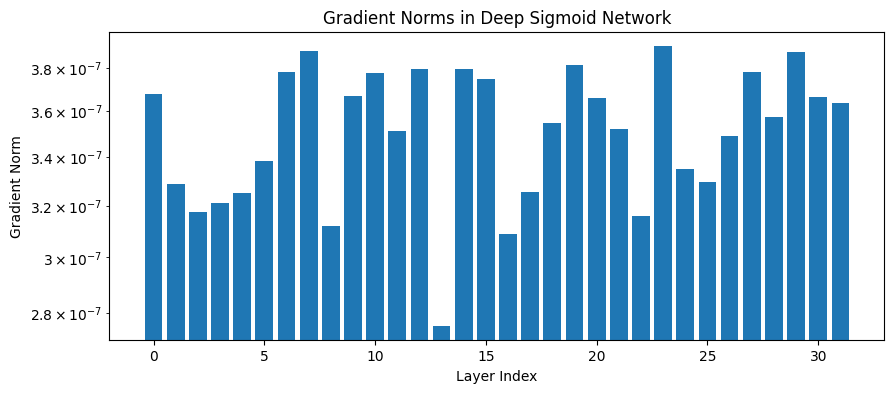

First layer gradient norm: 0.000000
Last layer gradient norm: 0.000000


In [113]:
# TODO: Compute gradients through the sigmoid network
# 1. Create a random input tensor (batch_size=32, features=10)
# 2. Forward pass through the network
# 3. Compute mean of output
# 4. Backward pass
# 5. Collect gradients from each Linear layer's weight.grad
x = torch.randn((32,10),requires_grad=True)
output = deep_sigmoid_network(x)
output.mean().backward()
sigmoid_gradients = x.grad
# Visualize gradient magnitudes
if sigmoid_gradients is not None:
    grad_norms = [torch.norm(g).item() for g in sigmoid_gradients]
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(grad_norms)), grad_norms)
    plt.xlabel('Layer Index')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norms in Deep Sigmoid Network')
    plt.yscale('log')
    plt.show()
    print(f"First layer gradient norm: {grad_norms[0]:.6f}")
    print(f"Last layer gradient norm: {grad_norms[-1]:.6f}")

In [114]:
# TODO: Calculate the vanishing gradient ratio
# Ratio = last_layer_gradient_norm / first_layer_gradient_norm
vanishing_ratio = np.linalg.norm(sigmoid_gradients[-1])/ np.linalg.norm(sigmoid_gradients[0])

if vanishing_ratio is not None:
    print(f"Vanishing gradient ratio: {vanishing_ratio:.8f}")
    print(f"This means the gradient shrinks by a factor of {1/vanishing_ratio:.2f}!")

Vanishing gradient ratio: 0.98917264
This means the gradient shrinks by a factor of 1.01!


In [115]:
# Test Section 1: Vanishing Gradients with Sigmoid
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE3_SECTIONS["Section 1: Vanishing Gradients with Sigmoid"]]
test_runner.test_section("Section 1: Vanishing Gradients with Sigmoid", validator, section_tests, locals())


Testing: Section 1: Vanishing Gradients with Sigmoid
❌ Deep network with sigmoid activations: Unexpected error: Exercise3Validator.test_deep_sigmoid_network() missing 1 required positional argument: 'context'
❌ Gradient computation through sigmoid network: Unexpected error: Exercise3Validator.test_sigmoid_gradients() missing 1 required positional argument: 'context'
❌ Calculation of gradient vanishing ratio: Unexpected error: Exercise3Validator.test_vanishing_gradient_ratio() missing 1 required positional argument: 'context'

❌ Section 1: Vanishing Gradients with Sigmoid - Some tests failed. Review the errors above.


False

## Section 2: Vanishing Gradients with Tanh

The hyperbolic tangent (tanh) function also suffers from vanishing gradients, though typically less severe than sigmoid. Let's compare.

In [116]:
# TODO: Create a deep network with tanh activations
# Similar structure to sigmoid network but with Tanh activations
deep_tanh_network = deep_sigmoid_network = nn.Sequential(
    nn.Linear(10,8),
    nn.Tanh(),
    nn.Linear(8,6),
    nn.Tanh(),
    nn.Linear(6,4),
    nn.Tanh(),
    nn.Linear(4,2),
    nn.Tanh(),
    nn.Linear(2,1),
    nn.Tanh()

)

if deep_tanh_network:
    print("Deep Tanh Network:")
    print(deep_tanh_network)

Deep Tanh Network:
Sequential(
  (0): Linear(in_features=10, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=6, bias=True)
  (3): Tanh()
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): Tanh()
  (6): Linear(in_features=4, out_features=2, bias=True)
  (7): Tanh()
  (8): Linear(in_features=2, out_features=1, bias=True)
  (9): Tanh()
)


In [121]:
# TODO: Compute gradients through the tanh network
# Follow the same process as with sigmoid network
x.grad.zero_()
output = deep_tanh_network(x)
output.mean().backward()
tanh_gradients = x.grad
# Compare sigmoid vs tanh gradient flow
if sigmoid_gradients is not None and tanh_gradients is not None:
    sigmoid_norms = [torch.norm(g).item() for g in sigmoid_gradients]
    tanh_norms = [torch.norm(g).item() for g in tanh_gradients]

    plt.figure(figsize=(10, 4))
    x = range(len(sigmoid_norms))
    plt.plot(x, tanh_norms, 'b-', label='Tanh', marker='s')
    plt.plot(x, sigmoid_norms, 'r-', label='Sigmoid', marker='o')

    plt.xlabel('Layer Index')
    plt.ylabel('Gradient Norm (log scale)')
    plt.title('Gradient Flow: Sigmoid vs Tanh')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

AttributeError: 'range' object has no attribute 'grad'

In [118]:
# Test Section 2: Vanishing Gradients with Tanh
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE3_SECTIONS["Section 2: Vanishing Gradients with Tanh"]]
test_runner.test_section("Section 2: Vanishing Gradients with Tanh", validator, section_tests, locals())


Testing: Section 2: Vanishing Gradients with Tanh
❌ Deep network with tanh activations: Unexpected error: Exercise3Validator.test_deep_tanh_network() missing 1 required positional argument: 'context'
❌ Gradient computation through tanh network: Unexpected error: Exercise3Validator.test_tanh_gradients() missing 1 required positional argument: 'context'

❌ Section 2: Vanishing Gradients with Tanh - Some tests failed. Review the errors above.


False

## Section 3: Exploding Gradients

Now let's create the opposite problem: exploding gradients. This typically happens with poor weight initialization or unstable network architectures.

In [119]:
# TODO: Create a network prone to exploding gradients
# Use large weight initialization (std=5.0 or multiply weights by 5)
# Use Linear layers without activation functions between them
unstable_network = deep_sigmoid_network = nn.Sequential(
    nn.Linear(10,8),
    nn.Linear(8,6),
    nn.Linear(6,4),
    nn.Linear(4,2),
    nn.Linear(2,1),
)



if unstable_network:
    print("Unstable Network (prone to exploding gradients):")
    for i, module in enumerate(unstable_network.modules()):
        if isinstance(module, nn.Linear):
            print(f"Layer {i}: Weight std = {module.weight.data.std():.3f}")

Unstable Network (prone to exploding gradients):
Layer 1: Weight std = 0.203
Layer 2: Weight std = 0.199
Layer 3: Weight std = 0.222
Layer 4: Weight std = 0.325
Layer 5: Weight std = 0.236


In [122]:
# TODO: Observe exploding gradients
# Compute gradients and watch them explode!
# You might see NaN or very large values
x.grad.zero_()
output = deep_tanh_network(x)
output.mean().backward()
exploding_gradients = x.grad

if exploding_gradients is not None:
    grad_norms = [torch.norm(g).item() if not torch.isnan(g).any() else float('nan')
                  for g in exploding_gradients]

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(grad_norms)), grad_norms)
    plt.xlabel('Layer Index')
    plt.ylabel('Gradient Norm')
    plt.title('Exploding Gradients!')
    plt.show()

    print("Gradient norms:")
    for i, norm in enumerate(grad_norms):
        print(f"Layer {i}: {norm:.2e}")

AttributeError: 'range' object has no attribute 'grad'

In [ ]:
# TODO: Implement gradient clipping
# Clip gradients to a maximum norm of 1.0
# Use torch.nn.utils.clip_grad_norm_

x.grad.zero_()
output = deep_tanh_network(x)

output.mean().backward()
torch.nn.utils.clip_grad_norm_(x,max_norm=0.001)
clipped_gradients = x.grad

if clipped_gradients is not None:
    clipped_norms = [torch.norm(g).item() for g in clipped_gradients]
    print("Clipped gradient norms:")
    for i, norm in enumerate(clipped_norms):
        print(f"Layer {i}: {norm:.4f}")
    print(f"\nMax gradient norm after clipping: {max(clipped_norms):.4f}")

In [ ]:
# Test Section 3: Exploding Gradients
section_tests = [(getattr(validator, name), desc) for name, desc in EXERCISE3_SECTIONS["Section 3: Exploding Gradients"]]
test_runner.test_section("Section 3: Exploding Gradients", validator, section_tests, locals())

### Section 4: Solutions - ReLU and Batch Normalization
Let's explore two popular solutions to gradient flow problems:

ReLU activations: Don't saturate for positive inputs
Batch Normalization: Stabilizes gradients by normalizing inputs

In [ ]:
# TODO: Create a deep network with ReLU activations
# Similar structure but use ReLU instead of sigmoid/tanh
relu_network = unstable_network = deep_sigmoid_network = nn.Sequential(
    nn.Linear(10,8),
    nn.ReLU(),
    nn.Linear(8,6),
    nn.ReLU(),
    nn.Linear(6,4),
    nn.ReLU(),
    nn.Linear(4,2),
    nn.ReLU(),
    nn.Linear(2,1),
    nn.ReLU()
)

if relu_network:
    print("ReLU Network:")
    print(relu_network)

In [ ]:
# TODO: Compute gradients through ReLU network
x.grad.zero_()
output = relu_network(x)
output.mean().backward()
relu_gradients = x.grad

# Compare all activation functions
if sigmoid_gradients is not None and tanh_gradients is not None and relu_gradients is not None:
    sigmoid_norms = [torch.norm(g).item() for g in sigmoid_gradients]
    tanh_norms = [torch.norm(g).item() for g in tanh_gradients]
    relu_norms = [torch.norm(g).item() for g in relu_gradients]

    plt.figure(figsize=(12, 5))
    x = range(len(sigmoid_norms))
    plt.plot(x, sigmoid_norms, 'r-', label='Sigmoid', marker='o')
    plt.plot(x, tanh_norms, 'b-', label='Tanh', marker='s')
    plt.plot(x, relu_norms, 'g-', label='ReLU', marker='^')
    plt.xlabel('Layer Index (deeper →)')
    plt.ylabel('Gradient Norm (log scale)')
    plt.title('Gradient Flow Comparison: Different Activation Functions')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate gradient preservation ratios
    for name, grads in [("Sigmoid", sigmoid_norms), ("Tanh", tanh_norms), ("ReLU", relu_norms)]:
        ratio = grads[-1] / grads[0] if grads[0] > 0 else 0
        print(f"{name} gradient preservation ratio: {ratio:.6f}")

In [ ]:
# TODO: Create a network with Batch Normalization
# Add BatchNorm1d layers after Linear layers (before activation)
batchnorm_network = None